<a href="https://colab.research.google.com/github/Siya-9/Homomorphic-Encryption/blob/main/Encrypted_convolution_with_FHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np

torch.manual_seed(73)

train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16561389.12it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 512986.87it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4510582.62it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4809525.06it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [2]:
class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        # the model uses the square activation function
        x = x * x
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x



In [3]:
def train(model, train_loader, criterion, optimizer, n_epochs=10):
    # model in training mode
    model.train()
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

    # model in evaluation mode
    model.eval()
    return model


In [4]:
model = ConvNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)

Epoch: 1 	Training Loss: 0.397561
Epoch: 2 	Training Loss: 0.130699
Epoch: 3 	Training Loss: 0.088399
Epoch: 4 	Training Loss: 0.071318
Epoch: 5 	Training Loss: 0.058989
Epoch: 6 	Training Loss: 0.050542
Epoch: 7 	Training Loss: 0.044438
Epoch: 8 	Training Loss: 0.038255
Epoch: 9 	Training Loss: 0.034721
Epoch: 10 	Training Loss: 0.030650


The above operation takes 2 mins.

In [5]:
def test(model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # model in evaluation mode
    model.eval()

    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )

test(model, test_loader, criterion)

Test Loss: 0.077934

Test Accuracy of 0: 98% (970/980)
Test Accuracy of 1: 99% (1128/1135)
Test Accuracy of 2: 98% (1013/1032)
Test Accuracy of 3: 99% (1004/1010)
Test Accuracy of 4: 98% (970/982)
Test Accuracy of 5: 98% (876/892)
Test Accuracy of 6: 98% (945/958)
Test Accuracy of 7: 98% (1008/1028)
Test Accuracy of 8: 97% (950/974)
Test Accuracy of 9: 96% (973/1009)

Test Accuracy (Overall): 98% (9837/10000)


In [6]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 18.0 MB/s eta 0:00:00


In [7]:
"""
It's a PyTorch-like model using operations implemented in TenSEAL.
    - .mm() method is doing the vector-matrix multiplication explained above.
    - you can use + operator to add a plain vector as a bias.
    - .conv2d_im2col() method is doing a single convolution operation.
    - .square_() just square the encrypted vector inplace.
"""

import tenseal as ts


class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()

        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()


    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)


In [8]:
def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    epoch = 0
    for data, target in test_loader:
        epoch += 1
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        enc_output = enc_model(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        print(f'At epoch {epoch}, test loss: {test_loss}')

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )



In [9]:
def save_model(model, filename):
    model_params = {
        'conv1_weight': model.conv1_weight,
        'conv1_bias': model.conv1_bias,
        'fc1_weight': model.fc1_weight,
        'fc1_bias': model.fc1_bias,
        'fc2_weight': model.fc2_weight,
        'fc2_bias': model.fc2_bias
    }
    with open(filename, 'wb') as f:
        pickle.dump(model_params, f)

def load_model(filename, torch_nn):
    with open(filename, 'rb') as f:
        model_params = pickle.load(f)

    model = EncConvNet(torch_nn)
    model.conv1_weight = model_params['conv1_weight']
    model.conv1_bias = model_params['conv1_bias']
    model.fc1_weight = model_params['fc1_weight']
    model.fc1_bias = model_params['fc1_bias']
    model.fc2_weight = model_params['fc2_weight']
    model.fc2_bias = model_params['fc2_bias']

    return model

In [10]:
num_test_samples = int(len(test_data)  * 0.1)
test_indices = np.random.choice(len(test_data), size=num_test_samples, replace=False)
test_data = torch.utils.data.Subset(test_data, test_indices)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = model.conv1.kernel_size
stride = model.conv1.stride[0]

In [11]:
## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [12]:
enc_model = EncConvNet(model)

In [14]:
import pickle

In [15]:
save_model(enc_model, 'enc_convnet_model.pkl')

enc_model = load_model('enc_convnet_model.pkl', model)

criterion = torch.nn.CrossEntropyLoss()

In [16]:
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride)

At epoch 1, test loss: 1.1920928244535389e-07
At epoch 2, test loss: 1.1920928244535389e-07
At epoch 3, test loss: 1.1920928244535389e-07
At epoch 4, test loss: 1.1920928244535389e-07
At epoch 5, test loss: 4.136477217997481e-05
At epoch 6, test loss: 0.00011467580042534564
At epoch 7, test loss: 0.00011467580042534564
At epoch 8, test loss: 0.00012182833233254087
At epoch 9, test loss: 0.00012194754161498622
At epoch 10, test loss: 0.00012194754161498622
At epoch 11, test loss: 0.00012337805206641406
At epoch 12, test loss: 0.008564031845580189
At epoch 13, test loss: 0.008575475871893445
At epoch 14, test loss: 0.008575475871893445
At epoch 15, test loss: 0.008575475871893445
At epoch 16, test loss: 0.0085846549453521
At epoch 17, test loss: 0.0085866815012281
At epoch 18, test loss: 0.14620915712531257
At epoch 19, test loss: 0.14620951475312438
At epoch 20, test loss: 0.14620951475312438
At epoch 21, test loss: 0.14620951475312438
At epoch 22, test loss: 0.14620951475312438
At epoc

The above operation takes 1 hr 37 mins for a test set of 1000 entries.

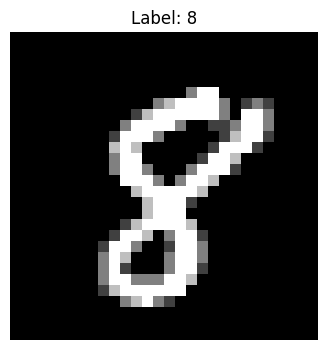

Encrypted image: <tenseal.tensors.ckksvector.CKKSVector object at 0x7f5dbf440cd0>
Predicted output: 8


In [17]:
import matplotlib.pyplot as plt

def predict(context, model, image, kernel_shape, stride):
    # Encoding and encryption
    x_enc, windows_nb = ts.im2col_encoding(
            context, image.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )

    # Encrypted evaluation
    enc_output = model(x_enc, windows_nb)
    print(f'Encrypted image: {enc_output}')
    # Decryption of result
    output = enc_output.decrypt()
    output = torch.tensor(output).view(1, -1)

    # Obtain predicted label
    _, pred = torch.max(output, 1)
    return pred.item()

random_image, random_label = test_data[521]
# Convert the image to a NumPy array
random_image_array = random_image.numpy().squeeze()
# Display the original image using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(random_image_array, cmap='gray')
plt.title(f"Label: {random_label}")
plt.axis('off')
plt.show()

print(f'Predicted output: {predict(context, enc_model, random_image, kernel_shape, stride )}')